## Homework 4

> Note: sometimes your answer doesn't match one of
> the options exactly. That's fine.
> Select the option that's closest to your solution.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mutual_info_score
pd.__version__

'2.2.2'

In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not.

In [4]:
# завантажити дані напряму за допомогою Pandas
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df_original = pd.read_csv(url)
df_original.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [5]:
# Check for missing values
print("Missing values before handling:")
print(df_original.isnull().sum())

# Handle missing values
df = df_original.copy()

# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

# Replace missing values
for col in categorical_features:
    df[col] = df[col].fillna('NA')

for col in numerical_features:
    df[col] = df[col].fillna(0.0)

print("\nMissing values after handling:")
print(df.isnull().sum())

# Split the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25 of 0.8 is 0.2

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

print(f"\nTrain set shape: {df_train.shape}")
print(f"Validation set shape: {df_val.shape}")
print(f"Test set shape: {df_test.shape}")

Missing values before handling:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Missing values after handling:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

Train set shape: (876, 8)
Validation set shape: (293, 8)
Test set shape: (293, 8)


### Question 1: ROC AUC feature importance


ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [6]:
from sklearn.metrics import roc_auc_score

numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    auc_scores[col] = auc

for col, auc in auc_scores.items():
    print(f"AUC for {col}: {auc:.3f}")

AUC for lead_score: 0.614
AUC for number_of_courses_viewed: 0.764
AUC for interaction_count: 0.738
AUC for annual_income: 0.552


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Convert DataFrames to dictionaries
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

# Apply DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities on the validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate and print the AUC on the validation set
auc_val = roc_auc_score(y_val, y_pred)
print(f"AUC on validation set: {auc_val:.3f}")

AUC on validation set: 0.817


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

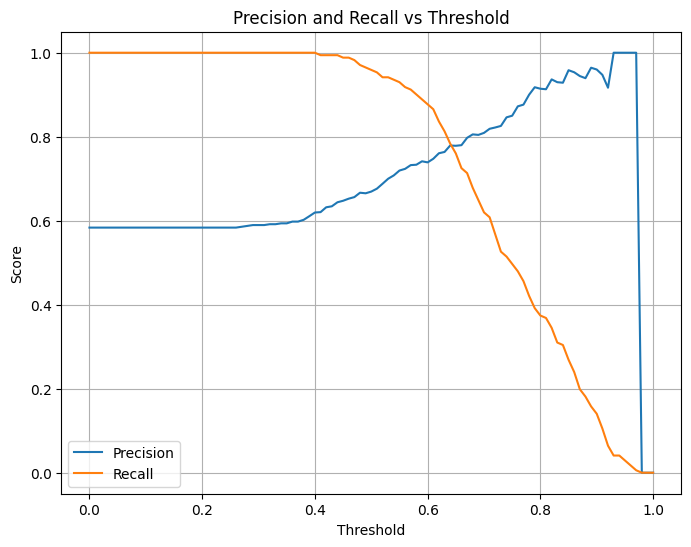

In [10]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred_binary = (y_pred >= t).astype(int)
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary)
    precision_scores.append(precision)
    recall_scores.append(recall)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both\n\nThis is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.\n\nLet's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01.

At which threshold F1 is maximal?
- 0.14
- 0.34
- 0.54
- 0.74

In [11]:
f1_scores = []
for p, r in zip(precision_scores, recall_scores):
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * (p * r) / (p + r)
    f1_scores.append(f1)

max_f1 = max(f1_scores)
max_f1_threshold = thresholds[f1_scores.index(max_f1)]

print(f"Maximum F1 score: {max_f1:.3f}")
print(f"Threshold at maximum F1 score: {max_f1_threshold:.3f}")

Maximum F1 score: 0.812
Threshold at maximum F1 score: 0.570


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [13]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores_cv = []

# Iterate over folds
for train_idx, val_idx in kfold.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]

    y_train_fold = df_train_fold['converted'].values
    y_val_fold = df_val_fold['converted'].values

    del df_train_fold['converted']
    del df_val_fold['converted']

    # Convert DataFrames to dictionaries
    train_dict_fold = df_train_fold.to_dict(orient='records')
    val_dict_fold = df_val_fold.to_dict(orient='records')

    # Apply DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(train_dict_fold)
    X_val_fold = dv.transform(val_dict_fold)

    # Train the logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)

    # Predict probabilities on the validation set
    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]

    # Calculate AUC and append to list
    auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores_cv.append(auc_fold)

# Calculate mean and standard deviation of AUC scores
mean_auc = np.mean(auc_scores_cv)
std_auc = np.std(auc_scores_cv)

print(f"Mean AUC across folds: {mean_auc:.3f}")
print(f"Standard deviation of AUC across folds: {std_auc:.3f}")

Mean AUC across folds: 0.822
Standard deviation of AUC across folds: 0.036


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [14]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# Define the C values to iterate over
C_values = [0.000001, 0.001, 1]

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

# Iterate over C values
for C in C_values:
    auc_scores_cv = []

    # Iterate over folds
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]

        y_train_fold = df_train_fold['converted'].values
        y_val_fold = df_val_fold['converted'].values

        del df_train_fold['converted']
        del df_val_fold['converted']

        # Convert DataFrames to dictionaries
        train_dict_fold = df_train_fold.to_dict(orient='records')
        val_dict_fold = df_val_fold.to_dict(orient='records')

        # Apply DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train_fold = dv.fit_transform(train_dict_fold)
        X_val_fold = dv.transform(val_dict_fold)

        # Train the logistic regression model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)

        # Predict probabilities on the validation set
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]

        # Calculate AUC and append to list
        auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
        auc_scores_cv.append(auc_fold)

    # Calculate mean and standard deviation of AUC scores for the current C
    mean_auc = np.mean(auc_scores_cv)
    std_auc = np.std(auc_scores_cv)

    results.append({'C': C, 'mean_auc': mean_auc, 'std_auc': std_auc})

# Print the results
for result in results:
    print(f"C: {result['C']}, Mean AUC: {result['mean_auc']:.3f}, Std AUC: {result['std_auc']:.3f}")

# Find the best C based on the criteria
best_C = None
best_mean_auc = -1
min_std_auc = float('inf')

for result in results:
    if result['mean_auc'] > best_mean_auc:
        best_mean_auc = result['mean_auc']
        min_std_auc = result['std_auc']
        best_C = result['C']
    elif result['mean_auc'] == best_mean_auc:
        if result['std_auc'] < min_std_auc:
            min_std_auc = result['std_auc']
            best_C = result['C']
        elif result['std_auc'] == min_std_auc:
            if result['C'] < best_C:
                best_C = result['C']

print(f"\nBest C: {best_C}")

C: 1e-06, Mean AUC: 0.560, Std AUC: 0.024
C: 0.001, Mean AUC: 0.867, Std AUC: 0.029
C: 1, Mean AUC: 0.822, Std AUC: 0.036

Best C: 0.001
